In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
# Assuming you have consumption data in wide format (columns are HASH_KEYs)
consumption_df = pd.read_csv('/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/FLASH/toShare/controlePreConsolide.csv')  # or your pre-period file
socio_df = pd.read_csv('/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/FLASH/toShare/socioEcodata.csv')  # your socioeconomic data



In [14]:
socio_df['AGE_GROUP'].value_counts()

AGE_GROUP
55-64      348
65-74      241
45-54      192
35-44      148
75+         81
25-34       78
18-24       44
Unknown      6
Name: count, dtype: int64

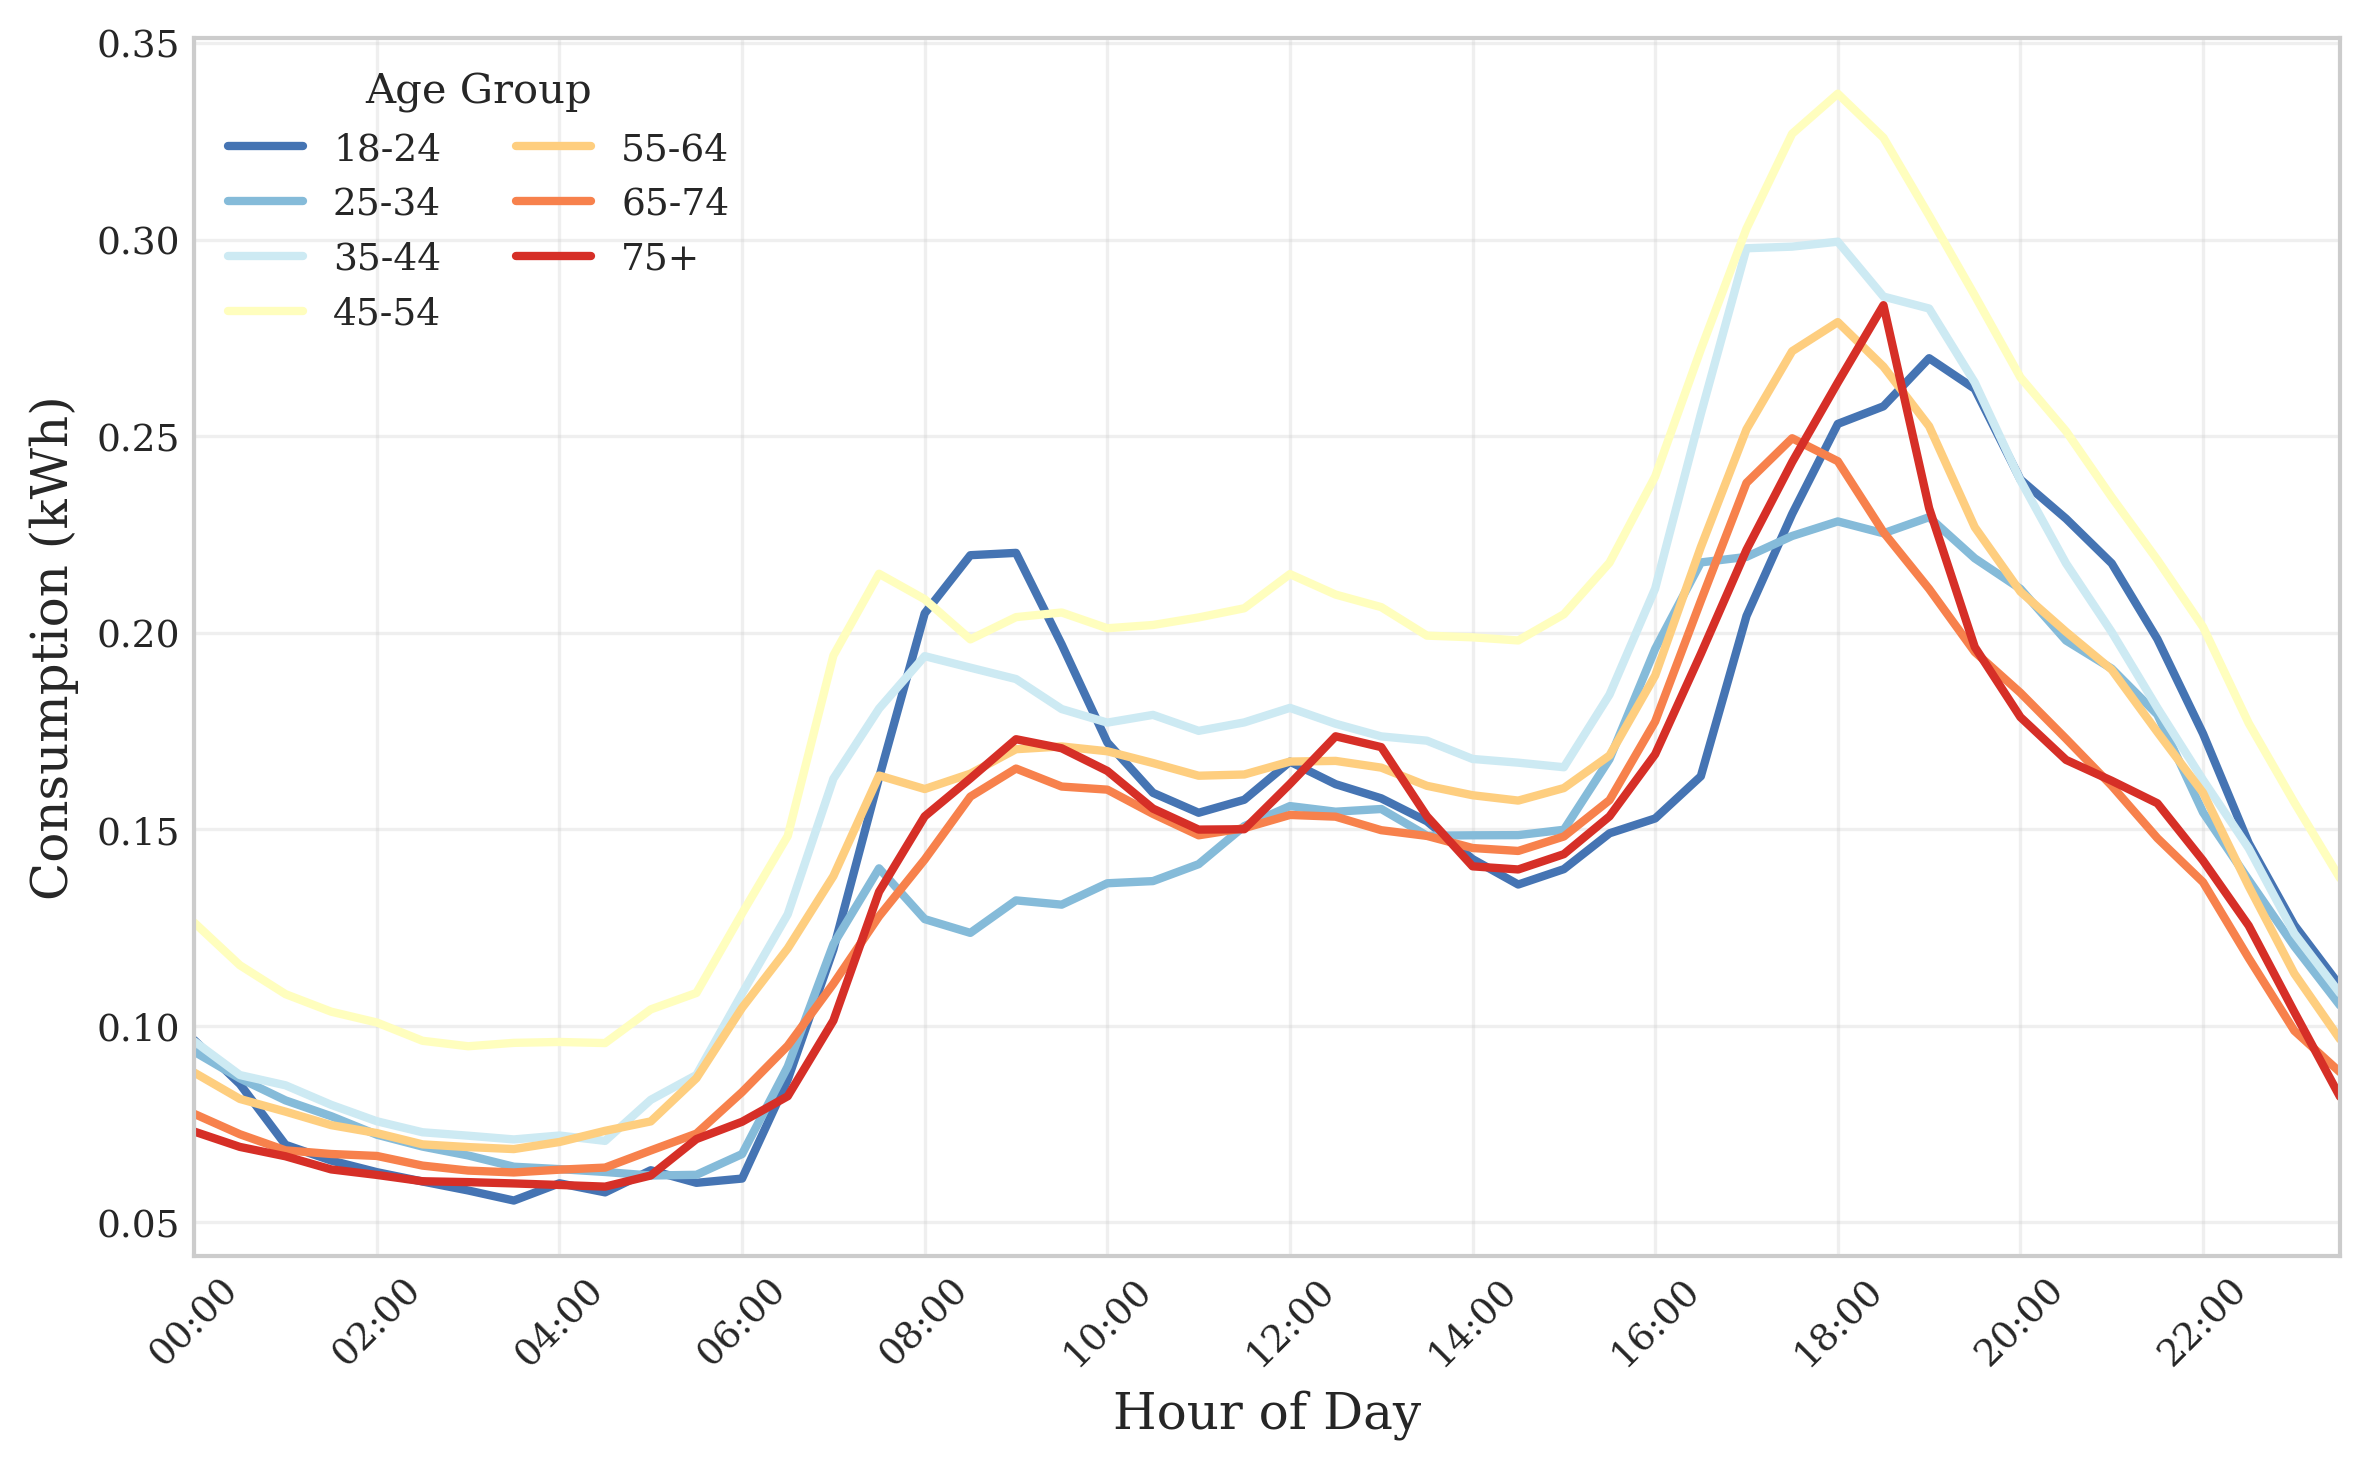

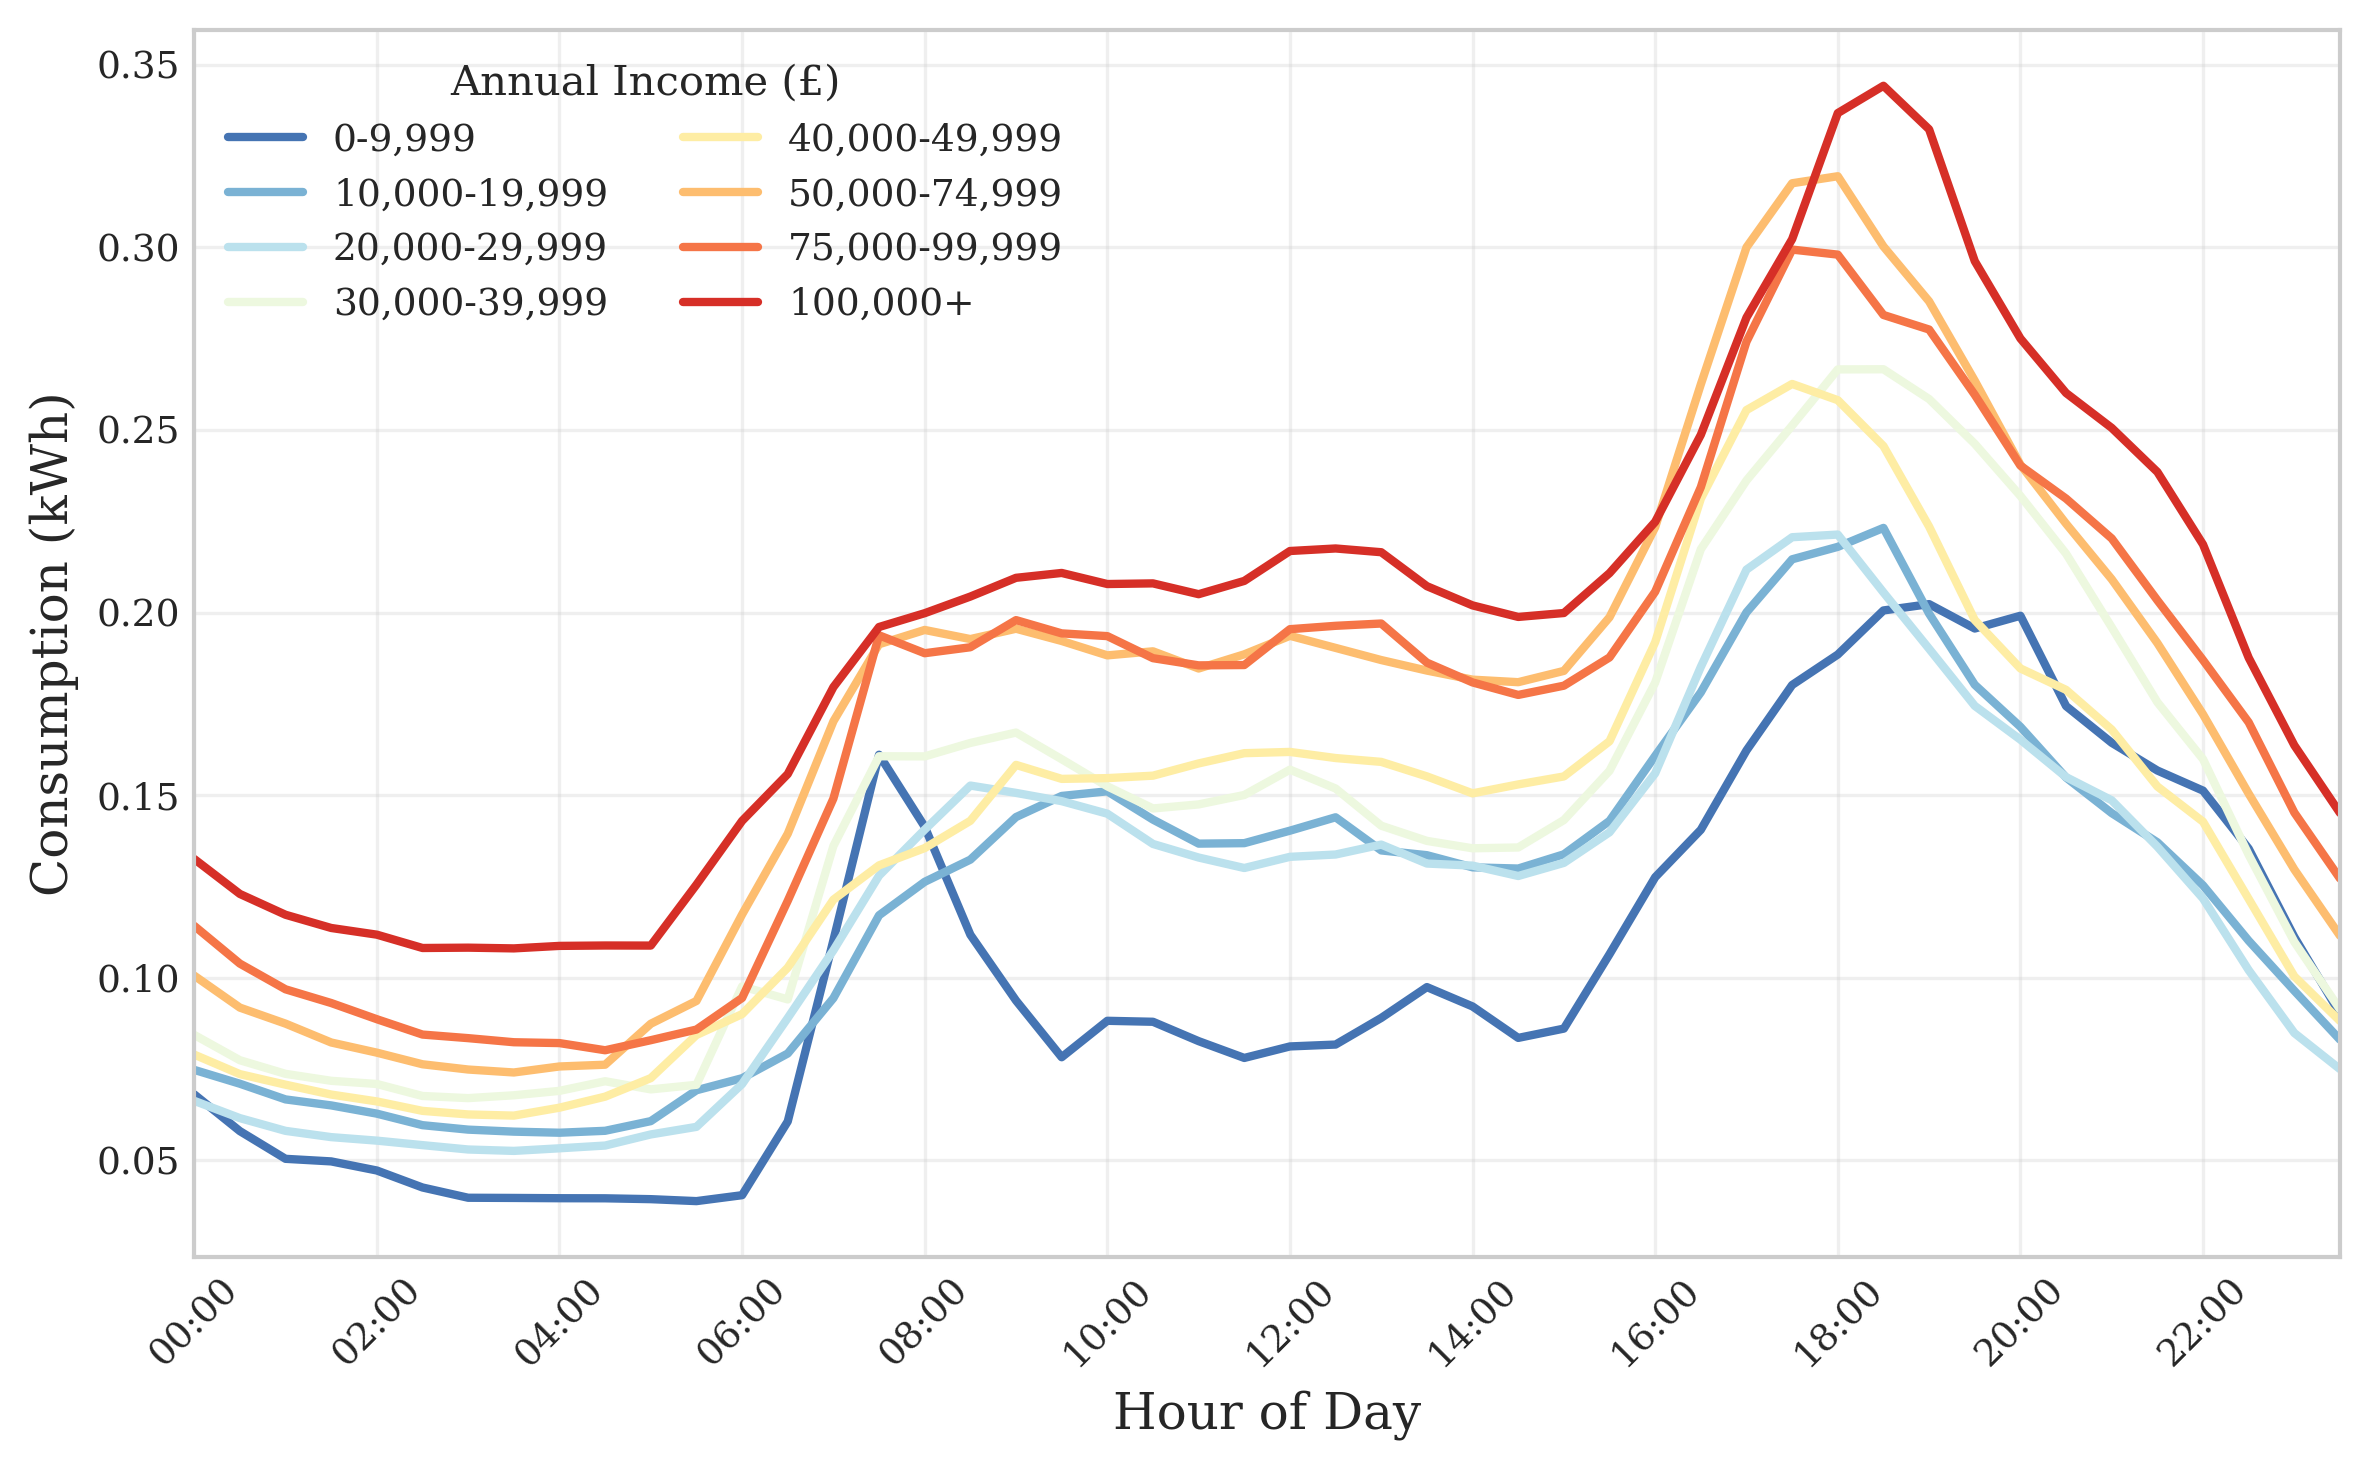

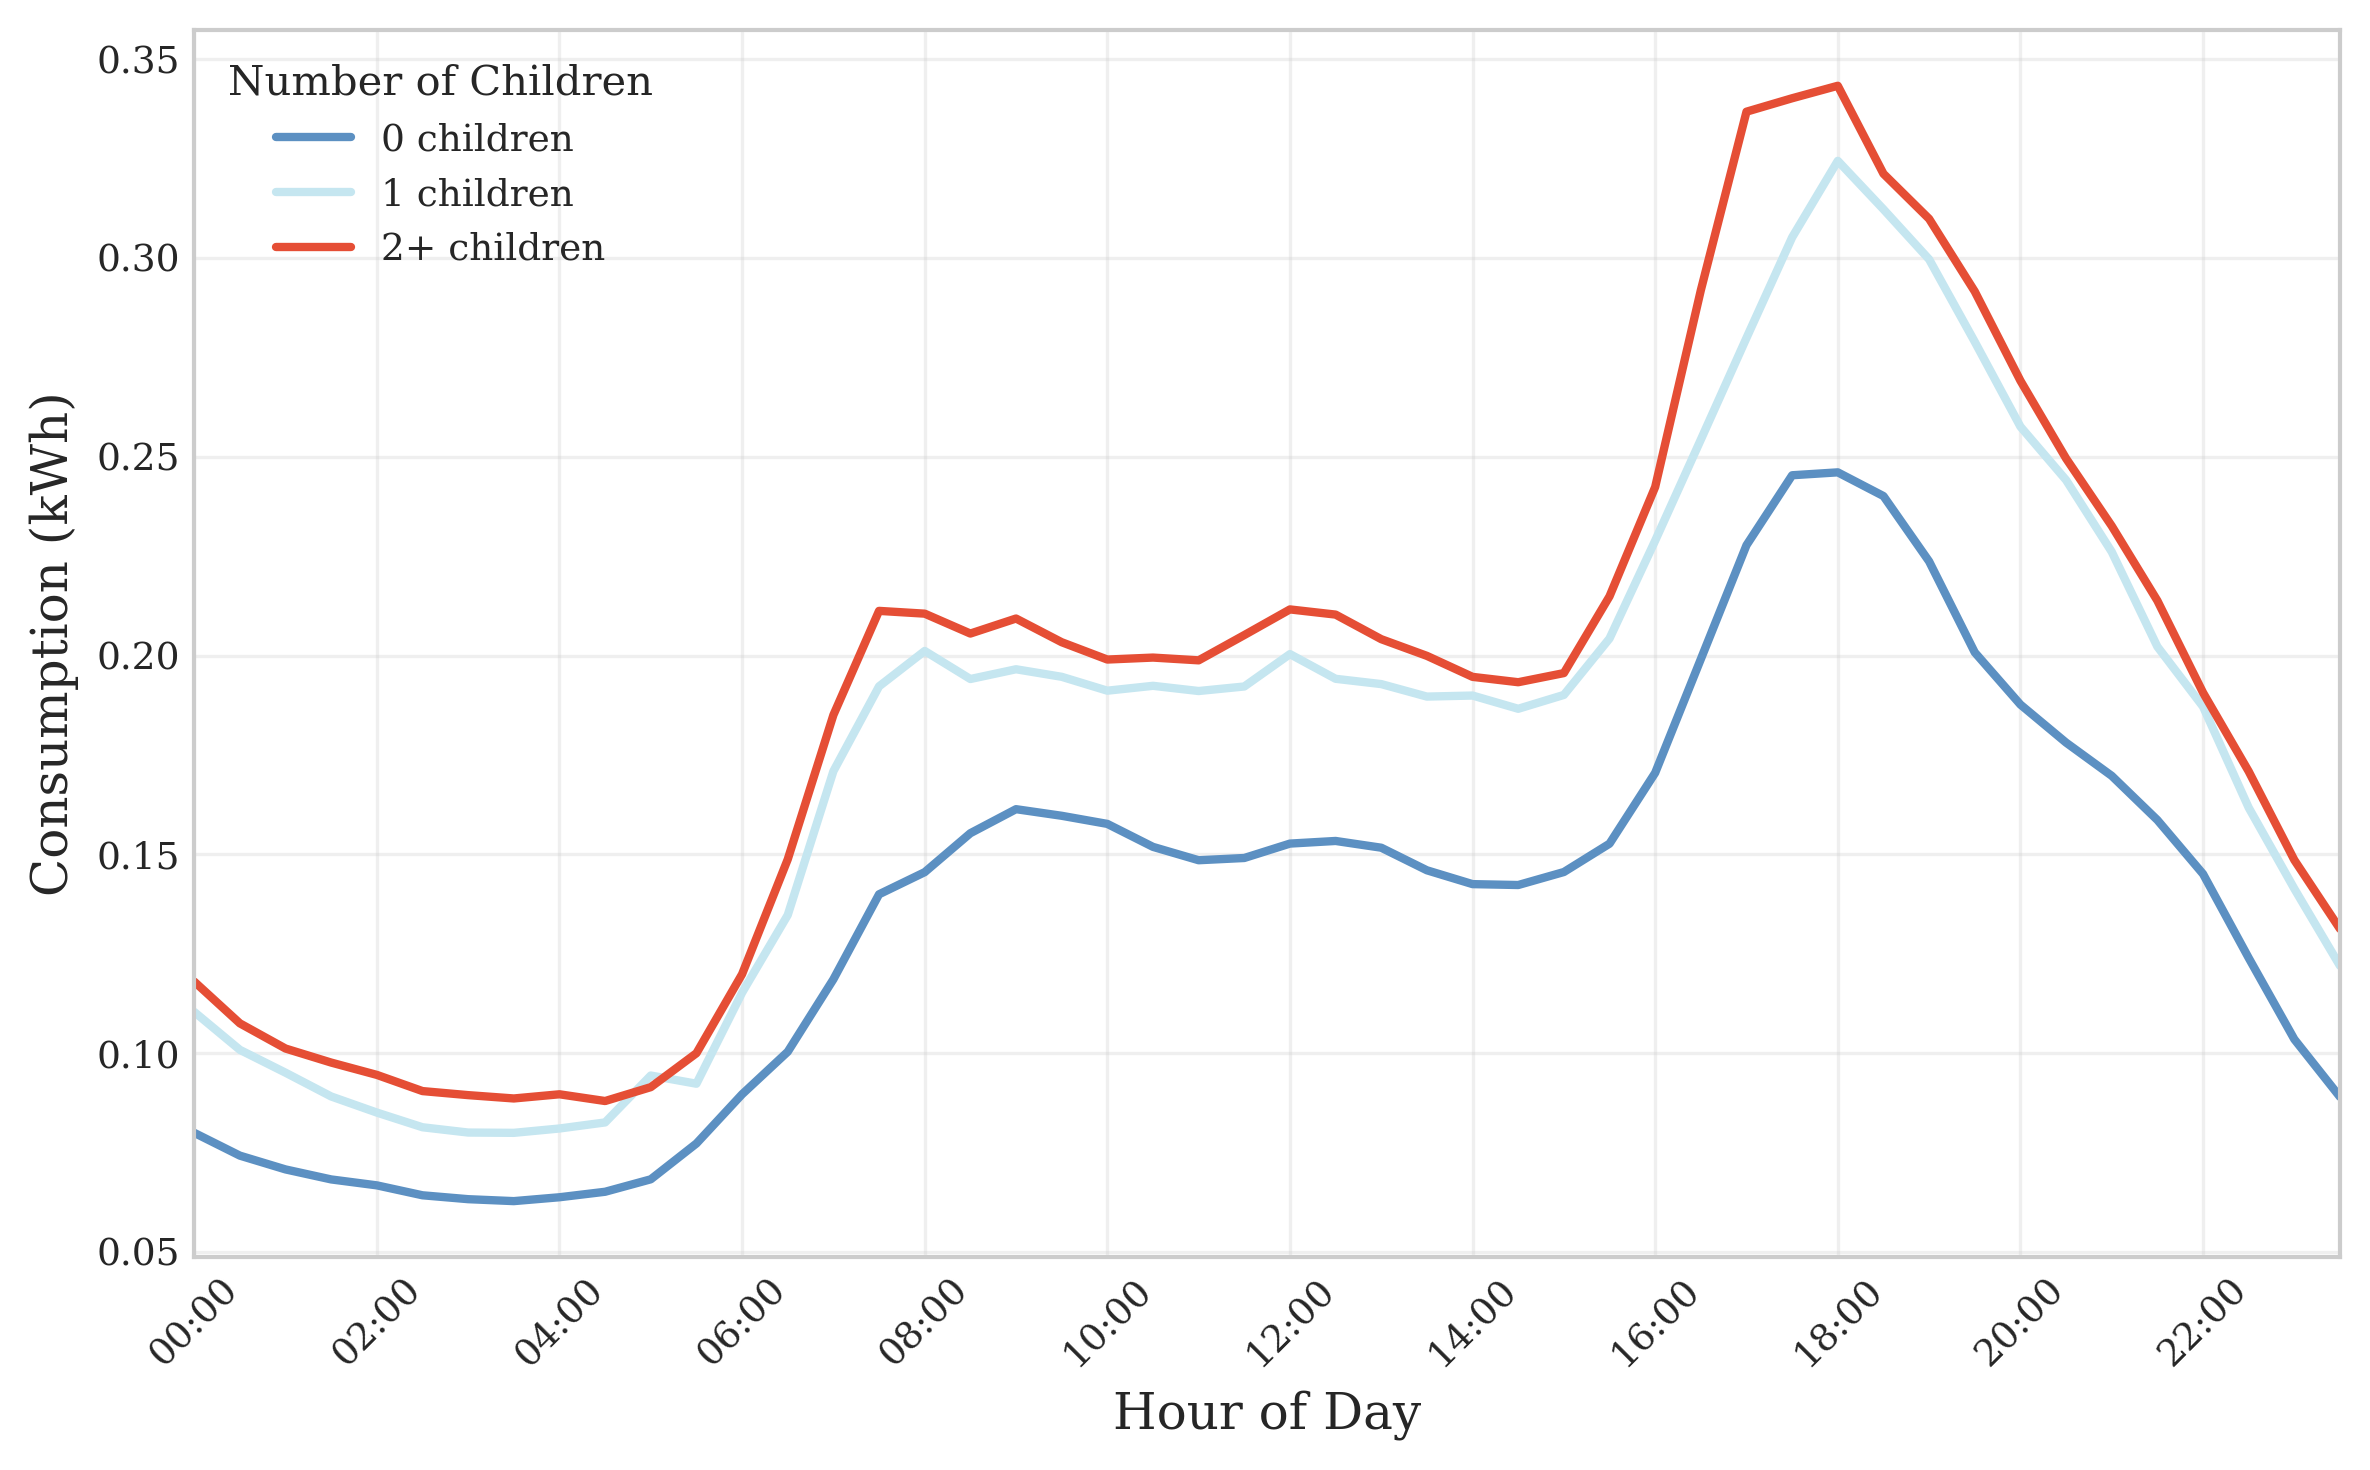

In [28]:
# Convert consumption data from wide to long format
# Assuming first column is timestamp
consumption_long = pd.melt(consumption_df, 
                          id_vars=['Unnamed: 0'],  # or whatever your time column is named
                          var_name='HASH_KEY',
                          value_name='consumption_kwh')

# Convert time to datetime and extract hour info
consumption_long['Unnamed: 0'] = pd.to_datetime(consumption_long['Unnamed: 0'])
consumption_long['hour'] = consumption_long['Unnamed: 0'].dt.hour
consumption_long['half_hour'] = consumption_long['Unnamed: 0'].dt.hour * 2 + (consumption_long['Unnamed: 0'].dt.minute // 30)

# Merge with socioeconomic data
merged_df = consumption_long.merge(socio_df, on='HASH_KEY', how='left')

# Calculate average consumption by half-hour for each group
def calculate_avg_curves(df, group_col):
    """Calculate average consumption curves for each group"""
    return df.groupby([group_col, 'half_hour'])['consumption_kwh'].agg(['mean', 'std', 'count']).reset_index()

# Academic paper style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1.8

# 1. Age Group Plot (Figure 1)
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 5))

age_curves = calculate_avg_curves(merged_df, 'AGE_GROUP')

# Define age order for logical plotting
age_order = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
age_curves['AGE_GROUP'] = pd.Categorical(age_curves['AGE_GROUP'], 
                                         categories=age_order, 
                                         ordered=True)

# Use RdYlBu_r colormap for age groups
age_colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, len(age_order)))

for idx, age in enumerate(age_order):
    if age in age_curves['AGE_GROUP'].values:
        age_data = age_curves[age_curves['AGE_GROUP'] == age]
        ax1.plot(age_data['half_hour'], age_data['mean'], 
                 label=age, linewidth=2, color=age_colors[idx])  # Removed markers

ax1.set_ylabel('Consumption (kWh)', fontsize=12)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.legend(loc='best', ncol=2, title='Age Group')  # Added title for consistency
ax1.set_xlim(0, 47)
ax1.grid(True, alpha=0.3)

# Format x-axis
hour_ticks = np.arange(0, 48, 4)  # Every 2 hours
hour_labels = [f'{h//2:02d}:00' for h in hour_ticks]
ax1.set_xticks(hour_ticks)
ax1.set_xticklabels(hour_labels, rotation=45)

plt.tight_layout()
plt.savefig('consumption_curves_age.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Income Level Plot (Figure 2)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))

income_curves = calculate_avg_curves(merged_df, 'INCOME_CATEGORY')

# Define income order
income_order = ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', 
                '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+']
income_curves['INCOME_CATEGORY'] = pd.Categorical(income_curves['INCOME_CATEGORY'], 
                                                  categories=income_order, 
                                                  ordered=True)

# Use RdYlBu_r colormap for income levels
income_colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, len(income_order)))

for idx, income in enumerate(income_order):
    if income in income_curves['INCOME_CATEGORY'].values:
        income_data = income_curves[income_curves['INCOME_CATEGORY'] == income]
        ax2.plot(income_data['half_hour'], income_data['mean'], 
                 label=income, linewidth=2, color=income_colors[idx])

ax2.set_ylabel('Consumption (kWh)', fontsize=12)
ax2.set_xlabel('Hour of Day', fontsize=12)
ax2.legend(loc='best', ncol=2, title='Annual Income (£)')
ax2.set_xlim(0, 47)
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.set_xticks(hour_ticks)
ax2.set_xticklabels(hour_labels, rotation=45)

plt.tight_layout()
plt.savefig('consumption_curves_income.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Children at Home Plot (Figure 3)
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 5))

children_curves = calculate_avg_curves(merged_df, 'CHILDREN_AT_HOME')

# Define order for children
children_order = ['0', '1', '2+']
children_curves['CHILDREN_AT_HOME'] = pd.Categorical(children_curves['CHILDREN_AT_HOME'], 
                                                     categories=children_order, 
                                                     ordered=True)

# Use RdYlBu_r colormap for children
children_colors = [plt.cm.RdYlBu_r(0.15), plt.cm.RdYlBu_r(0.35), plt.cm.RdYlBu_r(0.85)]

for idx, children in enumerate(children_order):
    if children in children_curves['CHILDREN_AT_HOME'].values:
        children_data = children_curves[children_curves['CHILDREN_AT_HOME'] == children]
        ax3.plot(children_data['half_hour'], children_data['mean'], 
                 label=f'{children} children', linewidth=2,  # Removed markers and made linewidth consistent
                 color=children_colors[idx])  # Removed fill_between

ax3.set_ylabel('Consumption (kWh)', fontsize=12)
ax3.set_xlabel('Hour of Day', fontsize=12)
ax3.legend(loc='best', title='Number of Children')  # Added title for consistency
ax3.set_xlim(0, 47)
ax3.grid(True, alpha=0.3)

# Format x-axis
ax3.set_xticks(hour_ticks)
ax3.set_xticklabels(hour_labels, rotation=45)

plt.tight_layout()
plt.savefig('consumption_curves_children.png', dpi=300, bbox_inches='tight')
plt.show()